In [35]:
import ipyleaflet
import ogr, os
import pandas as pd
import geopandas as gpd
import shapefile
import json 
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl, basemaps, basemap_to_tiles, GeoData
)

import pyproj
from shapely.ops import transform
from shapely.geometry import Polygon
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

from IPython.html import widgets
from IPython.display import display
import osmnx as ox
from tkinter import filedialog
from tkinter import *
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
import fiona
import numpy as np
import rasterio
import gdal
import urllib.request
import folium
from folium.plugins import Draw



zen=widgets.Select(
    options=['Entire Coastal Dataset', 'Estimated Onshore Dataset', 'Verified Onshore Dataset'],
    value='Entire Coastal Dataset',
    # rows=10,
    description='Satellite:',
    disabled=False
)

display(zen)


print('Enter Year Range of Interest Interest Below:')


y0=widgets.Text(
    value='yyyy',
    placeholder='Type something',
    description='Start Year:',
    disabled=False
)

display(y0)

y1=widgets.Text(
    value='yyyy',
    placeholder='Type something',
    description='End Year:',
    disabled=False
)

display(y1)



Select(description='Satellite:', options=('Entire Coastal Dataset', 'Estimated Onshore Dataset', 'Verified Ons…

Enter Year Range of Interest Interest Below:


Text(value='yyyy', description='Start Year:', placeholder='Type something')

Text(value='yyyy', description='End Year:', placeholder='Type something')

Retrieving Data, Please Wait
Data Retrieved! Now Subsetting to Year

Done. 1592 samples available from dates below map

Draw Spatial Query Below


Map(center=[35, -75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

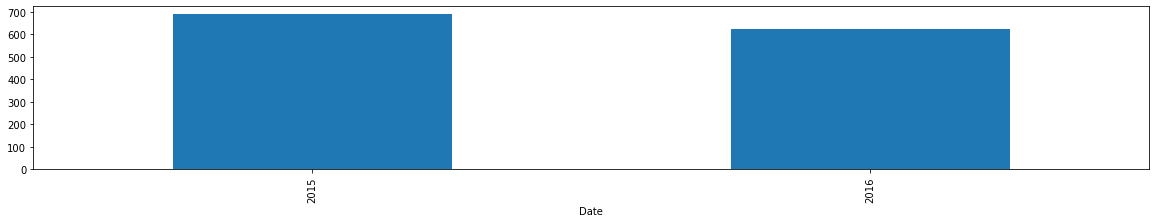

created
{'type': 'Feature', 'properties': {'style': {'stroke': True, 'color': '#0000FF', 'weight': 4, 'opacity': 0.5, 'fill': True, 'fillColor': None, 'fillOpacity': 0.2, 'clickable': True}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-81.664764, 30.925789], [-81.664764, 31.44741], [-80.956098, 31.44741], [-80.956098, 30.925789], [-81.664764, 30.925789]]]}}


In [36]:
if float(y1.value)-float(y0.value)<0:
    print('Error! End Date Proceeds Start Date!')
    
else:
    url = 'https://zenodo.org/record/5874231/files/'
    if zen.value=='Entire Coastal Dataset':
        filename='dataset_10kmcoast.csv'
    if zen.value=='Estimated Onshore Dataset':
        filename='Data_EstimatedOnshore.csv'
    if zen.value=='Verified Onshore Dataset':
        filename='Data_VerifiedOnshore.csv'

    url=(url+filename)
    print('Retrieving Data, Please Wait')
    #retrieve data
    df=pd.read_csv(url)
    print('Data Retrieved! Now Subsetting to Year')
    #subset by lower years
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df=df.loc[df.year>=float(y0.value), :]
    df=df.loc[df.year<=float(y1.value), :]

    df = pd.DataFrame(df.drop(columns='year'))

    if float(y1.value)-float(y0.value)>0:
        print()
        print('Done. '+str(len(df))+' samples available from dates below map')
        df=df[df['Date'].astype("datetime64").dt.year<2060] #remove any data with typos from source data
        #print statistics
        df['Mean'].groupby(df['Date'].astype("datetime64").dt.year).count().plot(kind="bar",figsize=(20,3))
        print()
        print('Draw Spatial Query Below')
    else:
        print('Done. '+str(len(df))+' samples available')
        print('Draw Spatial Query Below')

#make map with geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf['Date'] = gdf['Date'].astype(str)

gdf= GeoData(geo_dataframe = gdf)
watercolor = basemap_to_tiles(basemaps.Esri.WorldImagery, crs='espg:4326')

m = Map(layers=(watercolor, ), center=(35,-75 ), zoom=4)

m.add_layer(gdf)


#Add draw tool

dc = DrawControl(marker={'shapeOptions': {'color': '#0000FF'}},
                 rectangle={'shapeOptions': {'color': '#0000FF'}},
                 circle={'shapeOptions': {'color': '#0000FF'}},
                 circlemarker={},
                 )
def handle_draw(target, action, geo_json):
    print(action)
    print(geo_json)

dc.on_draw(handle_draw)
m.add_control(dc)
    

    
m

98 samples downloaded from dates:


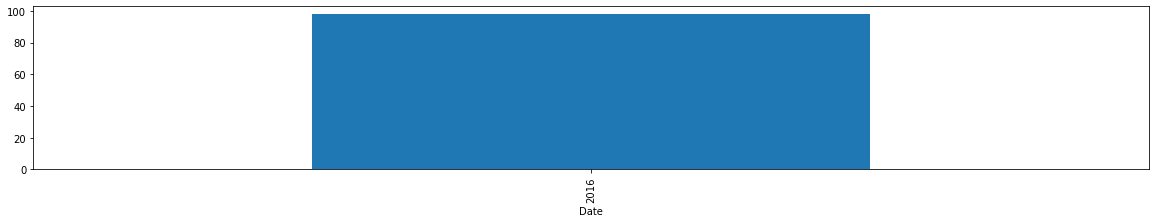

In [37]:
#This extracts the polygon drawn in the above map
bounds= (dc.last_draw).get("geometry").get("coordinates")[0]
bounds_poly=Polygon(bounds)
bounds_gpd=gpd.GeoDataFrame(geometry=[bounds_poly])
polygon=bounds_gpd.set_crs('EPSG:4326')
#These lines turn your dataset into a geodataframe and extract points within the polygon
df=gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
df=df.set_crs('EPSG:4326')
df=gpd.clip(df, polygon)
df=pd.DataFrame(df)
#Download to file
df.to_csv('../data.csv')
#Print date statistics if more than one year of data
if float(y1.value)-float(y0.value)>0:
    print(str(len(df))+' samples downloaded from dates:')
    df['Mean'].groupby(df['Date'].astype("datetime64").dt.year).count().plot(kind="bar",figsize=(20,3))
#Print length statistics if one year of data
else:
    print(str(len(df)) +'samples downloaded')

